### clustering


#### library import

In [10]:
!pip install --upgrade pandas-profiling
!pip install pydantic-settings
!pip install ydata-profiling
!pip install implicit
!pip install pyspark


You should consider upgrading via the '/Users/hankuklee/.pyenv/versions/3.10.2/bin/python3.10 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/hankuklee/.pyenv/versions/3.10.2/bin/python3.10 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/hankuklee/.pyenv/versions/3.10.2/bin/python3.10 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/hankuklee/.pyenv/versions/3.10.2/bin/python3.10 -m pip install --upgrade pip' command.
     |████████████████████████████████| 317.0 MB 33.3 MB/s eta 0:00:011     |██████████████▎                 | 140.9 MB 4.9 MB/s eta 0:00:36
     |████████████████████████████████| 200 kB 108.8 MB/s eta 0:00:01
Using legacy 'setup.py install' for pyspark, since package 'wheel' is not installed.
    Running setup.py install for pyspark ... done
You should consider upgrading via the '/Users/hankuklee/.pyenv/versions/3.10.2/bin/python3.10 -m pip install --upgrade pip

In [11]:
import pandas as pd               # for data manipulation
import numpy as np                # for aggregation functions
import gc                         # for clean-up memory
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
import random
from ydata_profiling import ProfileReport

from scipy import stats
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.sparse import csr_matrix

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import IncrementalPCA
from sklearn.cluster import MiniBatchKMeans

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import SparkSession


### data processing
#### 1. data load

In [3]:
path = '../dataset/'
random_sate = 1234

#### 요약

	•	구매 빈도: 각 사용자별 특정 제품 구매 횟수.
	•	재주문 비율: 사용자의 재주문 비율.
	•	구매 다양성: 사용자가 구매한 고유 제품의 수.
	•	구매 시간대 및 요일: 사용자의 평균 구매 시간대와 요일.
	•	구매 주기: 사용자의 평균 구매 주기.

이러한 특징으로 사용자의 구매 패턴을 효과적으로 분석할 수 있음.

K-Means 클러스터링을 통해 유사한 구매 행동을 보이는 사용자 그룹을 찾을 수 있음. 

각 그룹에 맞춤형 마케팅 전략을 적용하여 고객 만족도를 높이고 매출을 증대시킬 수 있음.

#### 데이터 설명
Instacart 데이터셋은 다음과 같은 주요 변수들을 포함하고 있습니다:

* user_id: 사용자 ID
* reorder_ratio: 재주문 비율 (사용자가 이전에 구매한 제품을 다시 구매한 비율)
* unique_product_count: 고유 제품 수 (사용자가 구매한 서로 다른 제품의 수)
* avg_order_hour: 평균 주문 시간 (시간대)
* avg_order_dow: 평균 주문 요일 (요일)
* avg_days_since_prior_order: 평균 주문 주기 (이전 주문 이후 경과 일수)
* cluster: 사용자가 속한 클러스터 레이블

k-means 클러스터링 + ALS 모델을 사용하여 사용자의 구매 패턴을 분석하고, 각 클러스터에 맞춤형 추천을 제공하는 추천 시스템을 구축

#### 데이터 전처리

In [5]:

# 데이터 로드
orders = pd.read_csv(path + 'orders.csv')
order_products_prior = pd.read_csv( path + 'order_products__prior.csv')
order_products_train = pd.read_csv( path + 'order_products__train.csv')
products = pd.read_csv( path + 'products.csv')
aisles = pd.read_csv( path + 'aisles.csv')
departments = pd.read_csv( path + 'departments.csv')

# 결측값 처리 (예시: 결측값을 0으로 대체)
orders.fillna(0, inplace=True)
order_products_prior.fillna(0, inplace=True)
order_products_train.fillna(0, inplace=True)

# 데이터 타입 변환 (예시: object 타입을 category 타입으로 변환)
orders['order_id'] = orders['order_id'].astype('category')
order_products_prior['order_id'] = order_products_prior['order_id'].astype('category')

# 필요 없는 피처 제거 (예시)
# 필요에 따라 제거할 피처를 결정합니다.
orders.drop(columns=['eval_set', 'order_number'], inplace=True)

orders

,order_id,user_id,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,2,8,0.0
1,2398795,1,3,7,15.0
2,473747,1,3,12,21.0
3,2254736,1,4,7,29.0
4,431534,1,4,15,28.0
...,...,...,...,...,...
3421078,2266710,206209,5,18,29.0
3421079,1854736,206209,4,10,30.0
3421080,626363,206209,1,12,18.0
3421081,2977660,206209,1,12,7.0


In [6]:
# 3. 피처 스케일링

from sklearn.preprocessing import StandardScaler

# 예시로 'order_dow'와 'order_hour_of_day' 피처를 스케일링
scaler = StandardScaler()
orders[['order_dow', 'order_hour_of_day']] = scaler.fit_transform(orders[['order_dow', 'order_hour_of_day']])


In [8]:
from sklearn.cluster import KMeans

# 클러스터링할 피처 선택
clustering_features = orders[['order_dow', 'order_hour_of_day']]

# k-means 모델 생성 및 학습
kmeans = KMeans(n_clusters=5, random_state=0)
orders['cluster'] = kmeans.fit_predict(clustering_features)

orders


,order_id,user_id,order_dow,order_hour_of_day,days_since_prior_order,cluster
0,2539329,1,-0.379230,-1.290086,0.0,1
1,2398795,1,0.109331,-1.526711,15.0,2
2,473747,1,0.109331,-0.343584,21.0,2
3,2254736,1,0.597891,-1.526711,29.0,2
4,431534,1,0.597891,0.366293,28.0,3
...,...,...,...,...,...,...
3421078,2266710,206209,1.086452,1.076169,29.0,3
3421079,1854736,206209,0.597891,-0.816835,30.0,2
3421080,626363,206209,-0.867791,-0.343584,18.0,1
3421081,2977660,206209,-0.867791,-0.343584,7.0,1


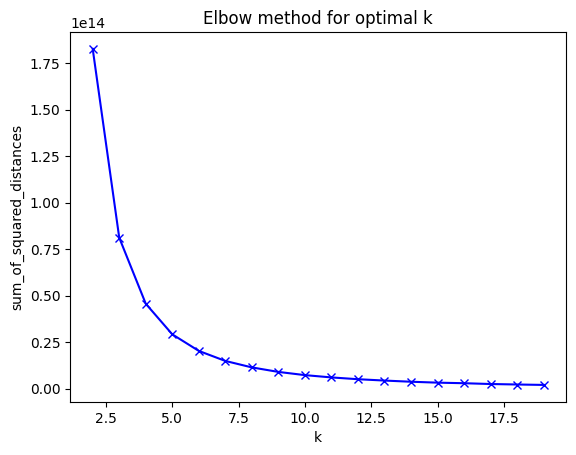

In [6]:
sum_of_squared_distances = []
K = range(2, 20)

for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(user_features)
    sum_of_squared_distances.append(km.inertia_)

plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')

plt.title('Elbow method for optimal k')
plt.show()

In [12]:
# Spark 세션 생성
spark = SparkSession.builder.appName("ALSExample").getOrCreate()

# 필요한 데이터프레임 결합
order_products = pd.concat([order_products_prior, order_products_train])

# ALS 모델 학습을 위한 데이터 준비
# user_id, product_id, rating은 예시 피처입니다. 실제 데이터에 맞게 변경하세요.
als_data = orders.merge(order_products, on='order_id').merge(products, on='product_id')
spark_df = spark.createDataFrame(als_data[['user_id', 'product_id', 'order_id']])

# ALS 모델 생성
als = ALS(userCol="user_id", itemCol="product_id", ratingCol="order_id", coldStartStrategy="drop")
model = als.fit(spark_df)

# 예측
predictions = model.transform(spark_df)


24/06/14 10:41:16 WARN Utils: Your hostname, iMac.local resolves to a loopback address: 127.0.0.1; using 192.168.50.237 instead (on interface en1)
24/06/14 10:41:16 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/14 10:41:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
# 새로운 주문에 대한 추천 예측
new_order_data = {'user_id': [1], 'product_id': [2], 'order_id': [3]}  # 예시 데이터
new_order_df = spark.createDataFrame(new_order_data)
recommendations = model.transform(new_order_df)


In [8]:
display(order_products_all)

,order_id,product_id,add_to_cart_order,reordered,user_id
0,2,33120,1,1,202279
1,2,28985,2,1,202279
2,2,9327,3,0,202279
3,2,45918,4,1,202279
4,2,30035,5,0,202279
...,...,...,...,...,...
33819101,3421063,14233,3,1,169679
33819102,3421063,35548,4,1,169679
33819103,3421070,35951,1,1,139822
33819104,3421070,16953,2,1,139822


In [9]:
from implicit.als import AlternatingLeastSquares
from scipy.sparse import csr_matrix

# 사용자-아이템 상호작용 행렬 생성
user_product_counts = order_products_all.groupby(['user_id', 'product_id']).size().reset_index(name='count')
display(user_product_counts)
# user_product_matrix = user_product_counts.pivot(index='user_id', columns='product_id', values='count').fillna(0)
# sparse_user_product_matrix = csr_matrix(user_product_matrix.values)

# # user_id와 행 인덱스 매핑 생성
# user_id_to_index = {user_id: idx for idx, user_id in enumerate(user_product_matrix.index)}


,user_id,product_id,count
0,1,196,11
1,1,10258,10
2,1,10326,1
3,1,12427,10
4,1,13032,4
...,...,...,...
13863741,206209,43961,3
13863742,206209,44325,1
13863743,206209,48370,1
13863744,206209,48697,1


In [10]:
# user_product_matrix = user_product_counts.pivot(index='user_id', columns='product_id', values='count').fillna(0)


In [11]:
# # ALS 모델 훈련
# als_model = AlternatingLeastSquares(factors=20, regularization=0.1, iterations=20)
# als_model.fit(sparse_user_product_matrix.T)

# # 예측을 위한 order_id 리스트
# test_orders = orders[orders.eval_set == 'test']

# # 예측 수행
# predictions = []
# for order_id in test_orders['order_id']:
#     user_id = test_orders[test_orders['order_id'] == order_id]['user_id'].values[0]
#     recommended = als_model.recommend(user_id, sparse_user_product_matrix[user_id], N=10)
#     recommended_products = ' '.join([str(product_id) for product_id in recommended])
  
        
#     predictions.append((order_id, recommended_products))

# # 예측 결과 데이터프레임 생성
# submission_df = pd.DataFrame(predictions, columns=['order_id', 'products'])

# # 제출 파일 저장
# submission_df.to_csv('submission.csv', index=False)


In [12]:
submission_df.info()

NameError: name 'submission_df' is not defined